## H2O gradient boosting and grid search

In this tutorial I will show you how to build and tune an H2O gbm model. I will first build a baseline gbm model without tuning the hyperparameters. Then I fine-tune the gbm model with hyperparameters in the gbm function. Then I use h2o.grid to conduct an extensive grid search to optimize the performance. You will see the model performance, measured by the area under the curve (AUC) in our case, has improved dramatically.

We will use the dataset [Gender recognition by voice](https://www.kaggle.com/primaryobjects/voicegender) on the Kaggle site.

The H2O’s GBM supports the following functionalities:
* Supervised learning for regression and classification tasks
* Distributed and parallelized computation on either a single node or a multi-node cluster
* Fast and memory-efficient Java implementations of the underlying algorithms
* User-friendly web interface to mirror the model building and scoring process running in R or Python
* Grid search for hyperparameter optimization and model selection
* Model export in plain Java code for deployment in production environments
* Additional parameters for model tuning.


We use h2o.init(nthreads=-1) to initilize an h2o environment. "Number of threads" is pretty much the number of CPUs used for a laptop. -1 means use all CPUs on the host (Default). A positive integer specifies the number of CPUs directly.

In [30]:
library(dplyr)
library(h2o)
h2o.init(nthreads=-1)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T//RtmpWgZL04/h2o_chriskuo_started_from_r.out
    /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T//RtmpWgZL04/h2o_chriskuo_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 81 milliseconds 
    H2O cluster timezone:       America/New_York 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.21.0.4353 
    H2O cluster version age:    8 days  
    H2O cluster name:           H2O_started_from_R_chriskuo_hpm901 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.78 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
   

In [31]:
df <- h2o.importFile(path = "/Users/chriskuo/Downloads/voice.csv")
dim(df)
summary(df,exact_quantiles=TRUE)

# Specify the response variable
response <- "label"

# Make the response variable a categorical variable
df[[response]] <- as.factor(df[[response]])      

## Exclude the variable 'Type'
predictors <- setdiff(names(df), 'label')
predictors

  |======================================================================| 100%


[1] 3168   21

 meanfreq          sd                median            Q25                
 Min.   :0.03936   Min.   :0.01836   Min.   :0.01097   Min.   :0.0002288  
 1st Qu.:0.16366   1st Qu.:0.04195   1st Qu.:0.16959   1st Qu.:0.1110865  
 Median :0.18484   Median :0.05916   Median :0.19003   Median :0.1402864  
 Mean   :0.18091   Mean   :0.05713   Mean   :0.18562   Mean   :0.1404556  
 3rd Qu.:0.19915   3rd Qu.:0.06702   3rd Qu.:0.21062   3rd Qu.:0.1759388  
 Max.   :0.25112   Max.   :0.11527   Max.   :0.26122   Max.   :0.2473469  
 Q75               IQR               skew              kurt              
 Min.   :0.04295   Min.   :0.01456   Min.   : 0.1417   Min.   :   2.068  
 1st Qu.:0.20875   1st Qu.:0.04256   1st Qu.: 1.6496   1st Qu.:   5.670  
 Median :0.22568   Median :0.09428   Median : 2.1971   Median :   8.318  
 Mean   :0.22476   Mean   :0.08431   Mean   : 3.1402   Mean   :  36.568  
 3rd Qu.:0.24366   3rd Qu.:0.11418   3rd Qu.: 2.9317   3rd Qu.:  13.649  
 Max.   :0.27347   Max.   :0.25

[1] "meanfreq" "sd"       "median"   "Q25"      "Q75"      "IQR"     
 [7] "skew"     "kurt"     "sp.ent"   "sfm"      "mode"     "centroid"
[13] "meanfun"  "minfun"   "maxfun"   "meandom"  "mindom"   "maxdom"  
[19] "dfrange"  "modindx"

### Split the data

Below is the standard syntax of h2o to split the dataset for training and testing purpose. In order to run and test on small samples, I use 10% for training and 10% for validation. H2o requires only two ratios. The third one is implied. So the test dataset is 90% (but I will not use it.)

In [32]:
splits <- h2o.splitFrame(
  data = df, 
  ratios = c(0.1,0.1),   # the ratios should sum up to to be less than 1.0. 
    destination_frames = c("train", "valid", "test"), seed = 1234
)
train <- splits[[1]]
valid <- splits[[2]]
test  <- splits[[3]]

### Learning Objective 1: Build a baseline gbm model without hyper-parameter tuning

Below I just use all the default values for the hyperpamaters. The AUC on the validation data is 0.569. 

In [33]:
gbm <- h2o.gbm(x = predictors, y = response, training_frame = train)
gbm

## Get the AUC on the validation set
h2o.auc(h2o.performance(gbm, newdata = valid)) 

  |======================================================================| 100%


Model Details:

H2OBinomialModel: gbm
Model ID:  GBM_model_R_1532025355299_41 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50               11060         4
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         5    4.98000          6         15    12.72000


H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.000328585
RMSE:  0.01812691
LogLoss:  0.008934396
Mean Per-Class Error:  0
AUC:  1
Gini:  1

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
       female male    Error    Rate
female    150    0 0.000000  =0/150
male        0  161 0.000000  =0/161
Totals    150  161 0.000000  =0/311

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.815335 1.000000  94
2                       max f2  0.815335 1.000000  94
3                 max f0point5  

[1] 0.9914063

### Find-tune hyper-parameters in h2o.gbm

The overall strategy is to test more trees and smaller learning rate. The hyperparameters for tuning are the following:

* Learning rate (shrinkage)
* Number of trees
* Interaction depth
* Minimum observation in a node
* Bag fraction (fraction of randomly selected observations)


The learning rate, a value between 0 and 1, corresponds to how quickly the error is corrected from each tree to the next. A small learning rate will result in long computational time, and a large learning rate makes the system unable to settle down. It will be efficient if the learning rate can decay over time. Therefore there is a hyperparameter to decay the learning rate called the "learn_rate_annealing". "Annealing", in materials science, describes a heating process that heats up in the beginning then cools down slowly. In gbm a common way to decay the learning rate is call the "step decay". It reduces the learning rate by some factor in every few iterations or epochs. Typical values are to reduce the learning rate by a half every 5 epochs. Because we use learning_rate_annealing, we can start with a large learning rate=0.05.

* learn_rate= 0.05.
* learn_rate_annealing=0.99.
* ntrees = 1000.
* max_runtime_secs=1200. Early stopping based on timeout. In this case no more than 1200 seconds.
* stopping_rounds = 5.
* stopping_tolerance = 1e-4.
* stopping_metric = "AUC". The above three hyperparameters control the early stopping when the AUC does not improve by at least 0.01% for 5 consecutive scoring events.
* score_tree_interval = 10. Score every 10 trees to make early stopping reproducible.

In [34]:
gbm <- h2o.gbm(x = predictors, y = response, 
               training_frame = train, 
               validation_frame = valid,
               learn_rate = .05, learn_rate_annealing =.99,
               ntrees=1000,
               stopping_rounds = 5,
               stopping_tolerance = 1e-4,
               stopping_metric = "AUC", 
               seed = 1234)

# print the auc for the validation data
print(h2o.auc(gbm, valid = TRUE))

  |======================================================================| 100%
[1] 0.9892323


### Learning Objective 2: Use Grid-search to find the optimal hyper-parameters

You can type "?h2o.grid()" to understand the grid serach options. The h2o.grid() reserves the following commands:

* hyper_params: List of lists of hyper parameters. 
* search_criteria: The default strategy 'Cartesian' covers the entire space of hyperparameter combinations. For example, if you have three hyperparameters and you have 2, 4, 6 values for each, the Catesian search will result in $2 * 4 * 6 = 48$ models. The alternative is 'RandomDiscrete' strategy to get random search of all the combinations of your hyperparameters. 
* algorithm: Which algorithm.
* grid_id: An id that we can retrieve it later. In this example is "my_grid".
* ntrees: The number of trees

In [35]:
hyper_params = list( ntrees = seq(100,3000,200), 
                    max_depth=seq(2,12,3)   )

grid <- h2o.grid(
  hyper_params = hyper_params,
  
  search_criteria = list(strategy = "Cartesian"),
  
  algorithm="gbm",
  
  grid_id="my_grid",
  
  # Below are is the same as h2o.gbm()
  x = predictors, 
  y = response, 
  training_frame = train, 
  validation_frame = valid,
  learn_rate = 0.05,                                                         
  learn_rate_annealing = 0.99,                                               
  sample_rate = 0.8,                                                       
  col_sample_rate = 0.8, 
  seed = 1234,                                                             
  stopping_rounds = 5,
  stopping_tolerance = 1e-4,
  stopping_metric = "AUC", 
  score_tree_interval = 10                                                
)

grid        

  |======================================================================| 100%


H2O Grid Details

Grid ID: my_grid 
Used hyper parameters: 
  -  max_depth 
  -  ntrees 
Number of models: 60 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
  max_depth ntrees        model_ids             logloss
1         8   1100 my_grid_model_22 0.10107007986622381
2         8   2700 my_grid_model_54 0.10107007986622381
3         8   1900 my_grid_model_38 0.10107007986622381
4         8    700 my_grid_model_14 0.10107007986622381
5         8    100  my_grid_model_2 0.10107007986622381

---
   max_depth ntrees        model_ids             logloss
55         2    300  my_grid_model_4 0.11186495832129566
56         2   1300 my_grid_model_24 0.11186495832129566
57         2    700 my_grid_model_12 0.11186495832129566
58         2   2500 my_grid_model_48 0.11186495832129566
59         2    900 my_grid_model_16 0.11186495832129566
60         2    100  my_grid_model_0 0.11463976462939442

In [19]:
## sort the grid models by decreasing AUC
sortedGrid <- h2o.getGrid("my_grid", sort_by="auc", decreasing = TRUE)    
print(sortedGrid)

H2O Grid Details

Grid ID: my_grid 
Used hyper parameters: 
  -  max_depth 
  -  ntrees 
Number of models: 60 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  max_depth ntrees        model_ids                auc
1         2    100  my_grid_model_0 0.9943614130434784
2         2   1900 my_grid_model_36 0.9941236413043478
3         2    900 my_grid_model_16 0.9941236413043478
4         2   1300 my_grid_model_24 0.9941236413043478
5         2   1700 my_grid_model_32 0.9941236413043478

---
   max_depth ntrees        model_ids                auc
55        11    300  my_grid_model_7 0.9920176630434783
56        11   1300 my_grid_model_27 0.9920176630434783
57        11    700 my_grid_model_15 0.9920176630434783
58        11   1100 my_grid_model_23 0.9920176630434783
59        11    100  my_grid_model_3 0.9920176630434783
60        11    500 my_grid_model_11 0.9920176630434783


You can print out the top 10 models from the grid search. Below the AUC has increased to 0.96.

In [36]:
for (i in 1:10) {
  gbm <- h2o.getModel(sortedGrid@model_ids[[i]])
  print(h2o.auc(h2o.performance(gbm, valid = TRUE)))
}

[1] 0.9943614
[1] 0.9941236
[1] 0.9941236
[1] 0.9941236
[1] 0.9941236
[1] 0.9941236
[1] 0.9941236
[1] 0.9941236
[1] 0.9941236
[1] 0.9941236


You can also understand the details of the best model.

In [37]:
best_model <- h2o.getModel(sortedGrid@model_ids[[1]])
summary(best_model)

scoring_history <- as.data.frame(best_model@model$scoring_history)
#plot(scoring_history$number_of_trees, scoring_history$training_MSE, type="p") #training mse
#points(scoring_history$number_of_trees, scoring_history$validation_MSE, type="l") #validation mse

## get the actual number of trees
ntrees <- best_model@model$model_summary$number_of_trees

Model Details:

H2OBinomialModel: gbm
Model Key:  my_grid_model_0 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1             100                      100               11281         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          4          4     4.00000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.01310199
RMSE:  0.1144639
LogLoss:  0.06946311
Mean Per-Class Error:  0.01310559
AUC:  0.9991718
Gini:  0.9983437

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
       female male    Error    Rate
female    147    3 0.020000  =3/150
male        1  160 0.006211  =1/161
Totals    148  163 0.012862  =4/311

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.307003 0.987654  83
2                       max f2  0.307003 0.991326  83
3                 max f

### Learning Objective 3: Plotting ROC, Precision-recall

* Use H2o metric functions available [here](https://rdrr.io/cran/h2o/man/h2o.metric.html).

### Learning Objective 4: Variable importance & Partial dependence plot

variable,relative_importance,scaled_importance,percentage
meanfun,550.7657471,1.0000000000,0.6593804490
IQR,178.1185760,0.3234016948,0.2132447547
Q25,92.3508301,0.1676771487,0.1105630336
sfm,2.3498189,0.0042664580,0.0028132190
mode,2.2270772,0.0040436016,0.0026662718
sd,1.8609920,0.0033789174,0.0022279921
sp.ent,1.8384672,0.0033380203,0.0022010253
maxfun,1.8082497,0.0032831557,0.0021648487
minfun,0.9400003,0.0017067152,0.0011253747
mindom,0.8494285,0.0015422683,0.0010169415


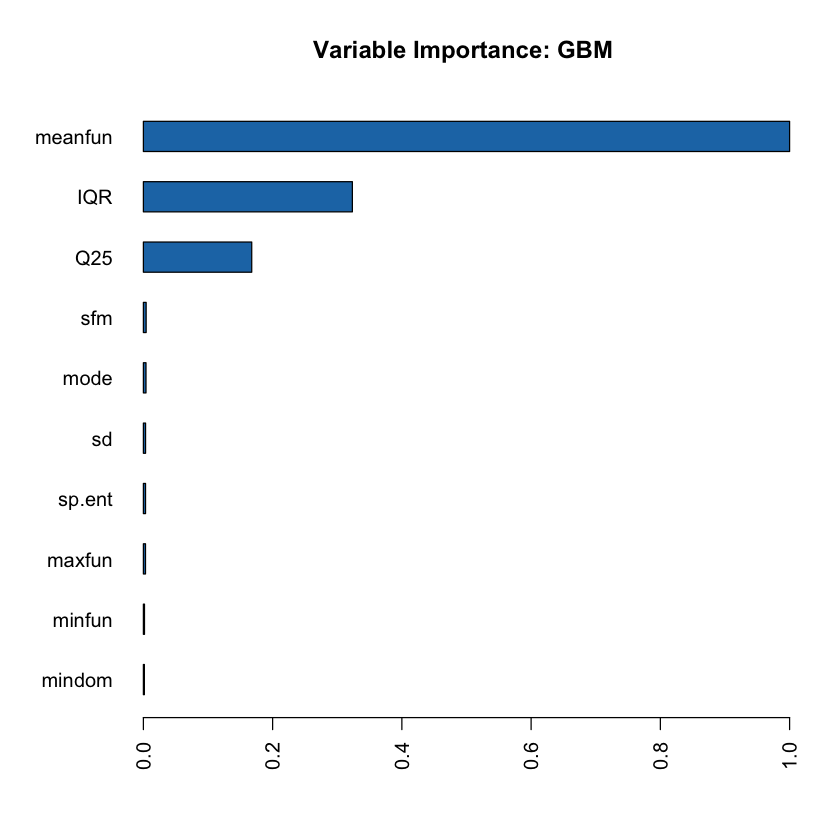

In [38]:
h2o.varimp(best_model)
h2o.varimp_plot(best_model)

  |======================================================================| 100%


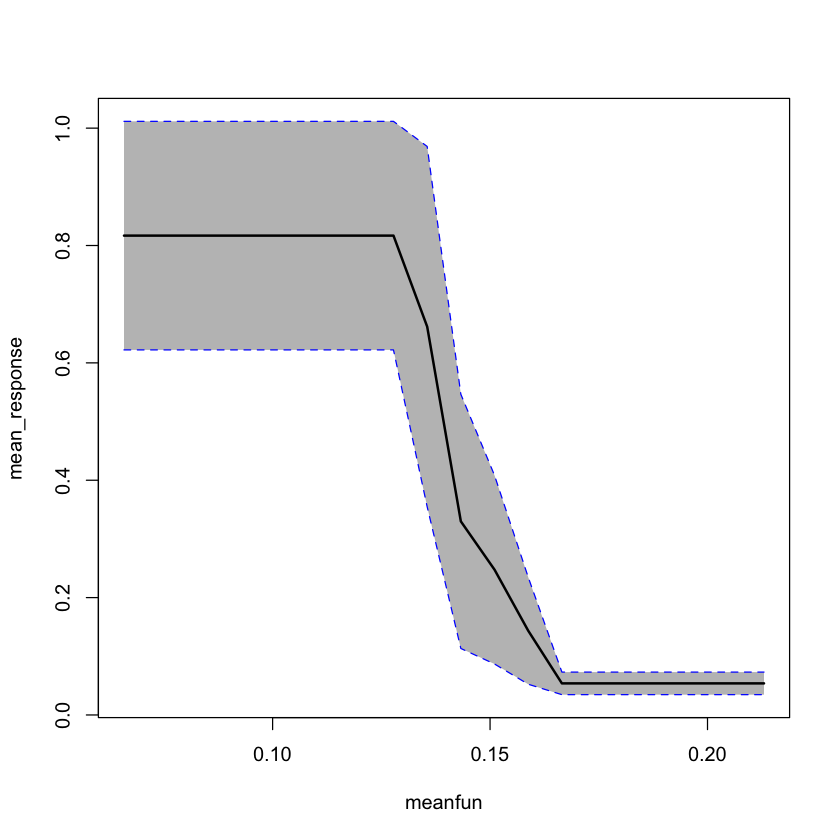

meanfun,mean_response,stddev_response,std_error_mean_response
0.06582745,0.81685055,0.19475300,0.011043429
0.07357286,0.81685055,0.19475300,0.011043429
0.08131826,0.81685055,0.19475300,0.011043429
0.08906367,0.81685055,0.19475300,0.011043429
0.09680908,0.81685055,0.19475300,0.011043429
0.10455449,0.81685055,0.19475300,0.011043429
0.11229990,0.81685055,0.19475300,0.011043429
0.12004530,0.81685055,0.19475300,0.011043429
0.12779071,0.81685055,0.19475300,0.011043429
0.13553612,0.66182784,0.30699151,0.017407892


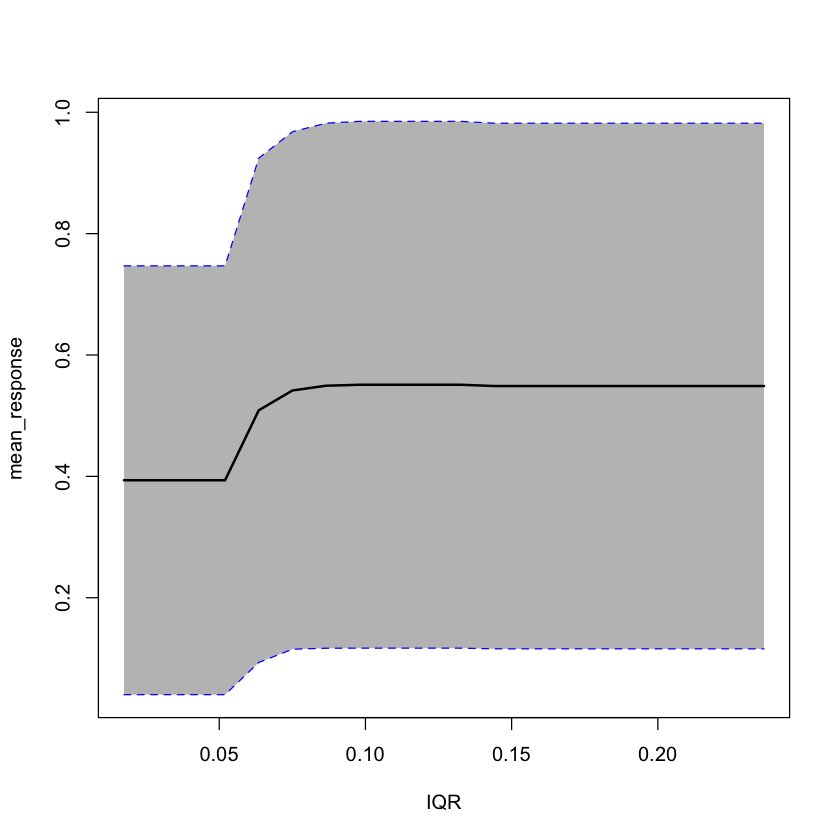

In [39]:
h2o.partialPlot(object = best_model, data = train, cols=c("meanfun","IQR"))

In [23]:
# All done. Shut down H2O.
h2o.shutdown(prompt=FALSE)

[1] TRUE